In [37]:
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os
import json
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

hands = mp.solutions.hands.Hands()

I0000 00:00:1738170894.871174 8835445 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2


In [2]:
DATA_FOLDER = "Sign-Dataset/"
TRAIN_DATA_FOLDER = DATA_FOLDER + "asl_alphabet_train/"
TEST_DATA_FOLDER = DATA_FOLDER + "asl_alphabet_test/"

In [51]:
image = cv2.imread(TRAIN_DATA_FOLDER + "A/A1.jpg")

In [52]:
def cv2_imshow(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axis
    plt.show()

In [8]:
mp_drawing = mp.solutions.drawing_utils

results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

landmark_frame = image.copy()

if results.multi_hand_landmarks:
  for hand_landmarks in results.multi_hand_landmarks:
    mp_drawing.draw_landmarks(landmark_frame, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS)

cv2_imshow(landmark_frame)


I0000 00:00:1738164546.927752 8835445 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2


NameError: name 'image' is not defined

In [6]:
dataset_split = {"Train": [], "Dev": [], "Test": []}

In [13]:
def get_landmarks(image_path):
    image = cv2.imread(image_path)
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    if results.multi_hand_landmarks:
        return results.multi_hand_landmarks[0].landmark
    else:
        return []

In [14]:
for class_name in os.listdir(TRAIN_DATA_FOLDER):
    class_path = TRAIN_DATA_FOLDER + class_name
    
    if not os.path.isdir(class_path):
        continue
        
    images = os.listdir(class_path)
    
    train_files, dev_files = train_test_split(images, test_size=0.2, random_state=42)
    
    for train_file in train_files:
        dataset_split["Train"].append({"file_path": class_path + "/" + train_file,
                                       "label": class_name,
                                       "landmarks": [(landmrk.x, landmrk.y) for landmrk in get_landmarks(class_path + "/" + train_file)]
                                       })
    for dev_file in dev_files:
        dataset_split["Dev"].append({"file_path": class_path + "/" + dev_file,
                                       "label": class_name,
                                       "landmarks": [(landmrk.x, landmrk.y) for landmrk in get_landmarks(class_path + "/" + dev_file)]
                                       })

for test_file in os.listdir(TEST_DATA_FOLDER):
    image_path = TEST_DATA_FOLDER + test_file
    class_name = test_file.split("_")[0]
    
    dataset_split["Test"].append({"file_path": image_path,
                                   "label": class_name,
                                   "landmarks": [(landmark.x, landmark.y) for landmark in get_landmarks(image_path)]
                                   })

with open("Sign-Dataset/dataset_split.json", "w") as f:
    json.dump(dataset_split, f, indent=4)

.DS_Store
R
U
I
N
G
Z
T
S
A
F
O
H
del
nothing
space
M
J
C
D
V
Q
X
E
B
K
L
Y
P
W


In [25]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

def analyze_and_visualize_landmarks(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Dictionary to store counts separately for Train and Dev
    dataset_counts = {
        "Train": defaultdict(lambda: {"total": 0, "with_landmarks": 0}),
        "Dev": defaultdict(lambda: {"total": 0, "with_landmarks": 0})
    }

    # Count instances per class for each dataset
    for split in ["Train", "Dev"]:
        for entry in data.get(split, []):
            class_name = entry["label"]
            landmarks = entry.get("landmarks", [])

            dataset_counts[split][class_name]["total"] += 1
            if landmarks:
                dataset_counts[split][class_name]["with_landmarks"] += 1

    # Function to plot bar chart
    def plot_bar_chart(dataset_name, class_counts):
        classes = list(class_counts.keys())
        total_counts = [class_counts[cls]["total"] for cls in classes]
        with_landmarks_counts = [class_counts[cls]["with_landmarks"] for cls in classes]

        x = np.arange(len(classes))
        width = 0.4

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.bar(x - width/2, total_counts, width, label="Total Examples", alpha=0.7)
        ax.bar(x + width/2, with_landmarks_counts, width, label="With Landmarks", alpha=0.9)

        ax.set_xlabel("Class")
        ax.set_ylabel("Number of Examples")
        ax.set_title(f"Landmark Presence Analysis - {dataset_name}")
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=45, ha="right")
        ax.legend()

        plt.tight_layout()
        plt.show()

    # Generate plots for Train and Dev
    for split in ["Train", "Dev"]:
        if dataset_counts[split]:  # Ensure there is data to plot
            plot_bar_chart(split, dataset_counts[split])

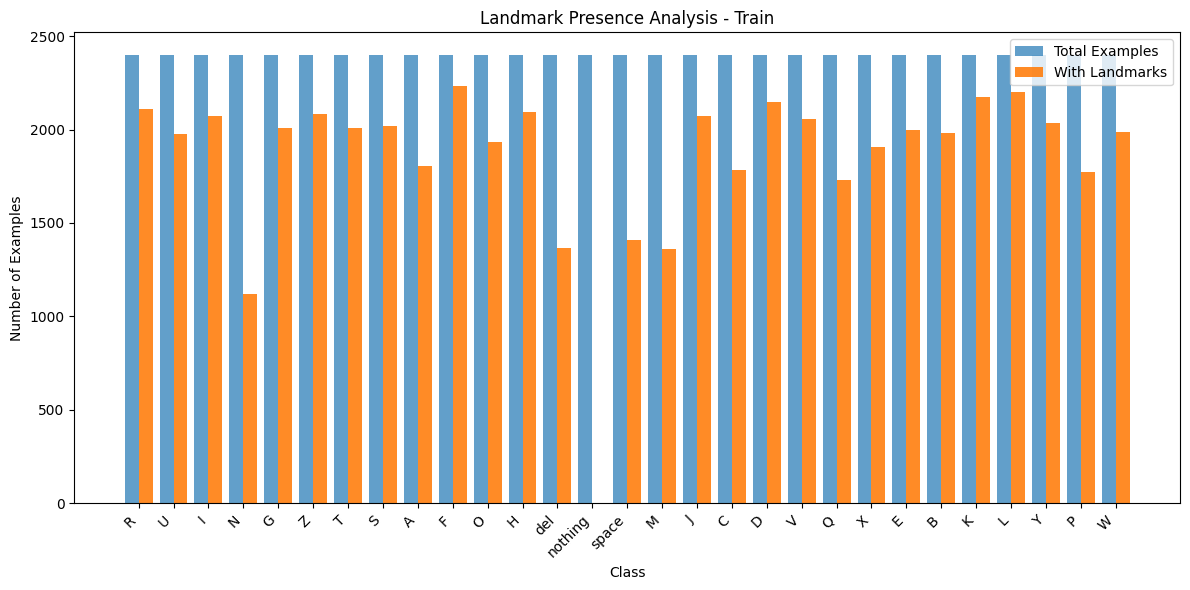

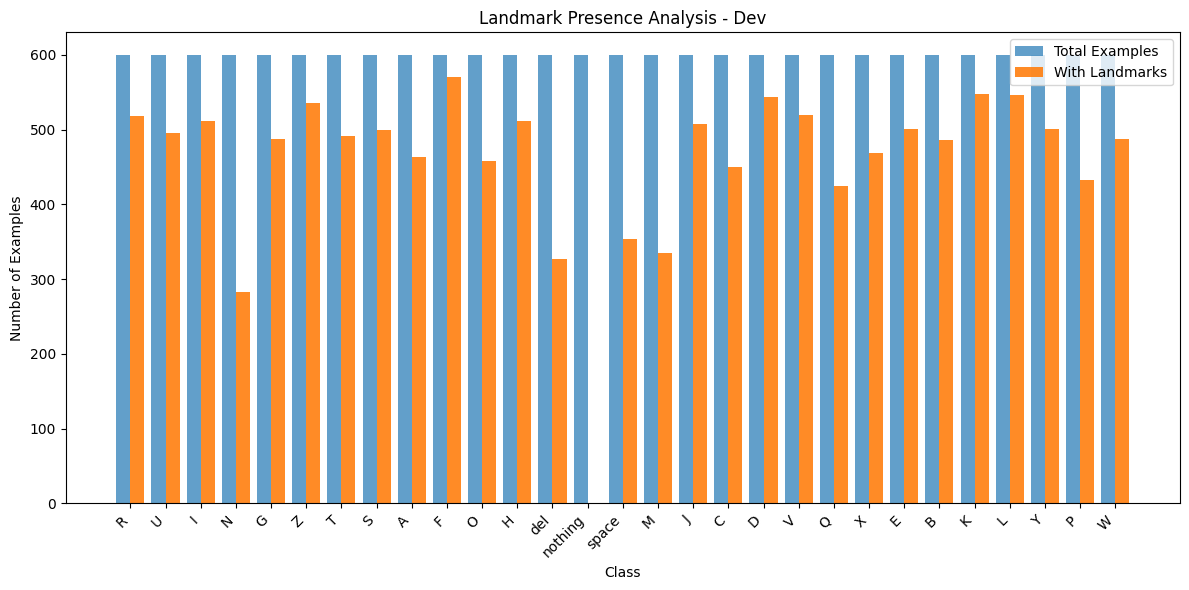

In [26]:
json_file = "Sign-Dataset/dataset_split.json"  # Replace with your actual file path
analyze_and_visualize_landmarks(json_file)

In [31]:
# Load and preprocess data
def load_data(json_file, exclude_class="nothing"):
    with open(json_file, 'r') as f:
        data = json.load(f)

    X_train, y_train = [], []
    X_dev, y_dev = [], []
    
    for split in ["Train", "Dev"]:
        for entry in data.get(split, []):
            class_name = entry["label"]
            landmarks = entry.get("landmarks", [])  # Fixed the typo from 'ladmarks'
            
            # Skip if class is "nothing"
            if class_name == exclude_class:
                continue

            if landmarks:
                if split == "Train":
                    X_train.append(np.array(landmarks))  # Add to training data
                    y_train.append(class_name)
                else:
                    X_dev.append(np.array(landmarks))  # Add to development data
                    y_dev.append(class_name)

    # Convert class labels to numerical values
    class_names = sorted(set(y_train + y_dev))  # Get unique class names from both splits
    class_to_index = {name: i for i, name in enumerate(class_names)}
    
    y_train = np.array([class_to_index[label] for label in y_train])  # Convert labels to indices
    y_dev = np.array([class_to_index[label] for label in y_dev])  # Convert labels to indices
    y_train = to_categorical(y_train, num_classes=len(class_names))  # One-hot encoding
    y_dev = to_categorical(y_dev, num_classes=len(class_names))  # One-hot encoding

    X_train = np.array(X_train)  # Convert input landmarks to NumPy array
    X_dev = np.array(X_dev)  # Convert input landmarks to NumPy array
    return X_train, y_train, X_dev, y_dev, class_names

# Create TensorFlow Dataset with batch processing
def create_tf_dataset(X, y, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=len(X))  # Shuffle data
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)  # Batch and optimize
    return dataset

Classes included: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'space']
Train batch X shape: (32, 21, 2)
Train batch y shape: (32, 28)
Dev batch X shape: (32, 21, 2)
Dev batch y shape: (32, 28)


In [32]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [34]:
# Load preprocessed data (from previous steps)
json_file = "Sign-Dataset/dataset_split.json"  # Replace with actual file
X_train, y_train, X_dev, y_dev, class_names = load_data(json_file)

# Get input shape (assuming landmarks have (x, y) coordinates)
input_shape = X_train.shape[1:]  # (num_landmarks, 2)
num_classes = len(class_names)

In [36]:
# Create model
model = create_cnn_model(input_shape, num_classes)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 19, 32)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 7, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,748 (135.73 KB)

 Trainable params: 34,748 (135.73 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Convert NumPy data to TensorFlow datasets
batch_size = 32
train_dataset = create_tf_dataset(X_train, y_train, batch_size)
dev_dataset = create_tf_dataset(X_dev, y_dev, batch_size)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=dev_dataset,
    epochs=100,  # Adjust epochs as needed
    callbacks=[early_stopping]
)

# Evaluate on the dev dataset
loss, accuracy = model.evaluate(dev_dataset)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
model.save("asl_hand_landmark_model.h5")
print("Model saved successfully!")


Epoch 1/100
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3806 - loss: 2.1384 - val_accuracy: 0.9031 - val_loss: 0.4398
Epoch 2/100
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8576 - loss: 0.5373 - val_accuracy: 0.9188 - val_loss: 0.3363
Epoch 3/100
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8848 - loss: 0.4314 - val_accuracy: 0.9090 - val_loss: 0.3173
Epoch 4/100
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9033 - loss: 0.3737 - val_accuracy: 0.9318 - val_loss: 0.2523
Epoch 5/100
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9084 - loss: 0.3366 - val_accuracy: 0.9397 - val_loss: 0.2257
Epoch 6/100
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9171 - loss: 0.3081 - val_accuracy: 0.9328 - val_loss: 0.2221
Epoch 7/100
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9262 - loss: 0.2763 - val_accuracy: 0.9485 - val_loss: 0.1874
Epoch 8/100
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9277 - loss: 0

Validation Accuracy: 97.07%
Model saved successfully!


In [43]:
# Load test data (same process as train/dev)
def load_test_data(json_file, class_names):
    with open(json_file, 'r') as f:
        data = json.load(f)

    X_test, y_test = [], []

    for entry in data.get("Test", []):  # Assuming test data is under "Test" key
        class_name = entry["label"]
        landmarks = entry.get("landmarks", [])  # Correct key name

        # Skip if no landmarks
        if not landmarks:
            continue

        X_test.append(np.array(landmarks))  # Convert landmarks to NumPy array
        y_test.append(class_name)

    # Convert class labels to indices based on training class names
    class_to_index = {name: i for i, name in enumerate(class_names)}
    y_test = np.array([class_to_index[label] for label in y_test if label in class_to_index])  # Filter out unknown labels
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(class_names))  # One-hot encoding

    X_test = np.array(X_test)  # Convert input landmarks to NumPy array
    return X_test, y_test

# Load the trained model
model = tf.keras.models.load_model("Models/asl_hand_landmark_model.h5")

# Load test dataset
test_json_file = "Sign-Dataset/dataset_split.json"  # Replace with actual test file path
X_test, y_test = load_test_data(test_json_file, class_names)

# Create TensorFlow dataset for test
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Evaluate the model on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 1.0000 - loss: 0.0225
Test Accuracy: 100.00%
